In [ ]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8

TRAIN_POSITIVE_SIZE = 460
TRAIN_NEGATIVE_SIZE = 4684
VALIDATION_POSITIVE_SIZE = 58
VALIDATION_NEGATIVE_SIZE = 562
TEST_POSITIVE_SIZE = 58
TEST_NEGATIVE_SIZE = 610

IMG_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/'
TRAIN_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/train'
VAL_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/validation'
TEST_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/test'

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical'
                                        )

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

test_generator = data_generator_no_aug.flow_from_directory(
                                        directory=TEST_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        )

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 5144 images belonging to 3 classes.
Found 620 images belonging to 3 classes.
Found 668 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = vgg16.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg16 = Model(vgg16.input, output)

res_name = []
for layer in vgg16.layers:
    res_name.append(layer.name)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
res_name[-21:]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'global_max_pooling2d',
 'flatten']

In [ ]:
set_trainable = False
for layer in vgg16.layers:
    if layer.name in res_name[-21:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 3

model = Sequential()
model.add(vgg16)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 16,292,675
Trainable params: 16,292,675
Non-trainable params: 0
____________________________________________

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [ ]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [ ]:
model.fit(
          train_generator,     
          epochs = 12,
          callbacks=[early_stop,reduce_lr],
          validation_data = validation_generator
          )

Epoch 1/12
643/643 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.6835 - f1_score: 0.4365

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


643/643 [==============================] - 1945s 3s/step - loss: 0.8086 - accuracy: 0.6835 - f1_score: 0.4365 - val_loss: 0.6633 - val_accuracy: 0.6613 - val_f1_score: 0.3257
Epoch 2/12
643/643 [==============================] - 219s 340ms/step - loss: 0.5346 - accuracy: 0.7694 - f1_score: 0.6548 - val_loss: 0.3851 - val_accuracy: 0.8887 - val_f1_score: 0.8466
Epoch 3/12
643/643 [==============================] - 213s 332ms/step - loss: 0.4672 - accuracy: 0.8175 - f1_score: 0.7292 - val_loss: 0.5321 - val_accuracy: 0.8210 - val_f1_score: 0.7728
Epoch 4/12
643/643 [==============================] - 213s 331ms/step - loss: 0.3575 - accuracy: 0.8791 - f1_score: 0.8279 - val_loss: 0.4592 - val_accuracy: 0.8661 - val_f1_score: 0.8540
Epoch 5/12
643/643 [==============================] - 213s 330ms/step - loss: 0.3084 - accuracy: 0.8948 - f1_score: 0.8608 - val_loss: 0.2437 - val_accuracy: 0.9290 - val_f1_score: 0.9158
Epoch 6/12
643/643 [==============================] - 213s 332ms/step - l

In [ ]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

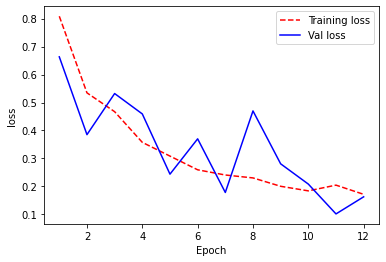

In [ ]:
get_diagnostic_plot(model,'loss')

In [ ]:
save_path = 'vgg16/'
tf.keras.models.save_model(model,save_path)

INFO:tensorflow:Assets written to: vgg16/assets


In [ ]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

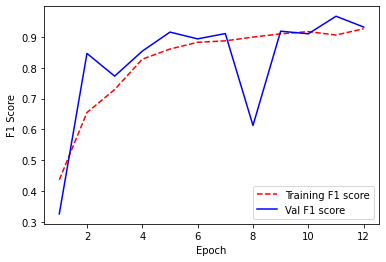

In [ ]:
training_loss = f1_scores
test_loss = f1_scores_val

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

In [ ]:
model.evaluate(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


84/84 [==============================] - 165s 2s/step - loss: 0.1762 - accuracy: 0.9416 - f1_score: 0.9127


[0.1761772781610489,
 0.9416167736053467,
 array([0.86274505, 0.9158879 , 0.95947427], dtype=float32)]

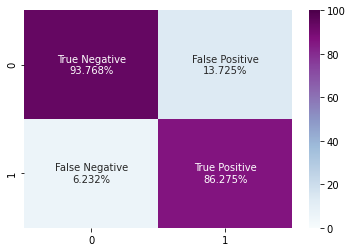

In [ ]:
import seaborn as sns

f1_scores = np.array([0.86274505, 0.9158879 , 0.95947427])

tp = f1_scores[0] * TEST_POSITIVE_SIZE
tn = ((f1_scores[1] + f1_scores[2])/2) * TEST_NEGATIVE_SIZE
fp = (1-f1_scores[0]) * TEST_NEGATIVE_SIZE
fn = (((1-f1_scores[1]) + (1-f1_scores[2]))/2) * TEST_POSITIVE_SIZE

cf_matrix = np.array([[tn / TEST_NEGATIVE_SIZE * 100, fp / TEST_NEGATIVE_SIZE * 100],
                      [fn / TEST_POSITIVE_SIZE * 100, tp / TEST_POSITIVE_SIZE * 100]
                    ])

group_names = ['True Negative','False Positive','False Negative','True Positive']
percentages = [tn / TEST_NEGATIVE_SIZE, fp / TEST_NEGATIVE_SIZE, fn / TEST_POSITIVE_SIZE, tp / TEST_POSITIVE_SIZE]
group_percentages = ["{0:.3%}".format(value) for value in percentages]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, vmin = 0, vmax = 100, annot=labels, fmt='', cmap='BuPu')

In [ ]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Sensitivity: 0.9326328585288695
Specificity: 0.8723133790932964
